Download FER-2013 from Kaggle

In [9]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
# Specify the directory to save the dataset
save_directory_data = os.path.expanduser('~/Downloads')
os.makedirs(save_directory_data, exist_ok=True)
# Download the dataset
os.system(f'kaggle datasets download -d msambare/fer2013 -p "{save_directory_data}"')

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0


 98%|█████████▊| 59.0M/60.3M [00:05<00:00, 9.70MB/s]

100%|██████████| 60.3M/60.3M [00:05<00:00, 10.6MB/s]


0

In [1]:
import cv2
import matplotlib.pyplot as plt
import random
from collections import Counter
import numpy as np
import pandas as pd
import random
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from skimage import exposure


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    s

In [3]:
# Directory paths
train_dir = os.path.expanduser('~/Downloads/fer2013/train')
test_dir = os.path.expanduser('~/Downloads/fer2013/test')

In [4]:
# Define a function to load data
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                labels.append(label)
    return images, labels

# Load training and testing images
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)

print(f"Loaded {len(train_images)} training images and {len(test_images)} testing images.")

Loaded 28709 training images and 7178 testing images.


In [5]:
# Define a function to count the number of images in each category
def count_images_per_category(labels, dataset_label):
    category_counts = Counter(labels)
    total_images = len(labels)
    
    # Print the counts for each category
    print(f"\n{dataset_label} set:")
    for category, count in category_counts.items():
        print(f"Category '{category}': {count} images")
    
    print(f"Total number of images in {dataset_label} set: {total_images}")
    return category_counts, total_images

# Count images in training and testing
train_counts, num_train_images = count_images_per_category(train_labels, "Training")
test_counts, num_test_images = count_images_per_category(test_labels, "Testing")


Training set:
Category 'happy': 7215 images
Category 'sad': 4830 images
Category 'fear': 4097 images
Category 'surprise': 3171 images
Category 'neutral': 4965 images
Category 'angry': 3995 images
Category 'disgust': 436 images
Total number of images in Training set: 28709

Testing set:
Category 'happy': 1774 images
Category 'sad': 1247 images
Category 'fear': 1024 images
Category 'surprise': 831 images
Category 'neutral': 1233 images
Category 'angry': 958 images
Category 'disgust': 111 images
Total number of images in Testing set: 7178


Visualzie Random Samples from Each Category

Label: disgust


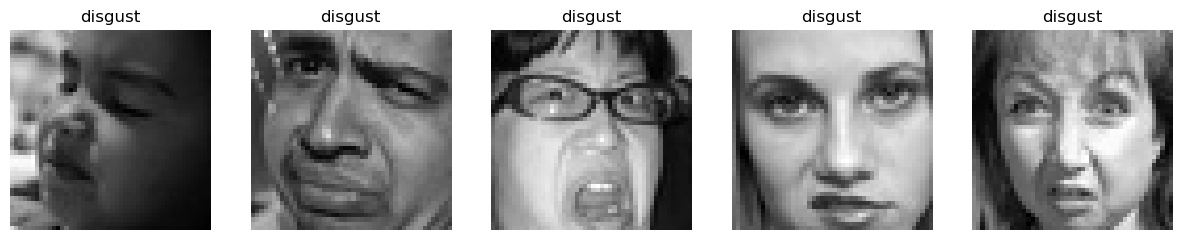

Label: happy


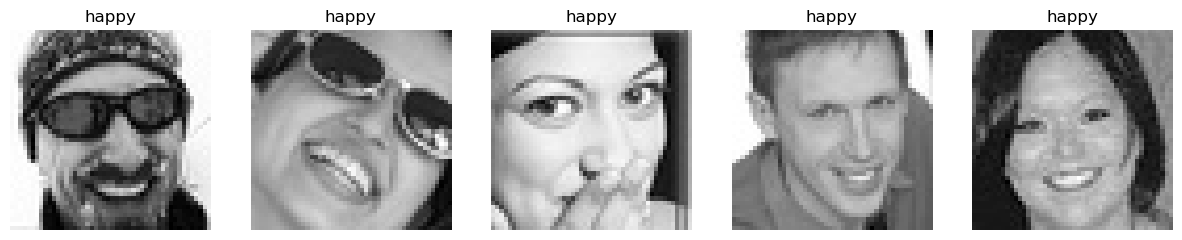

Label: sad


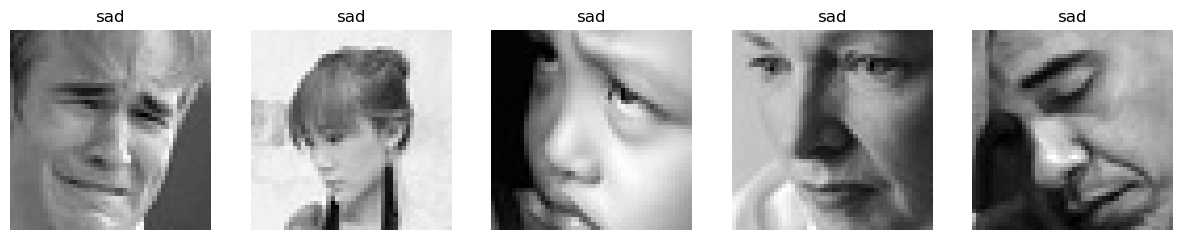

Label: neutral


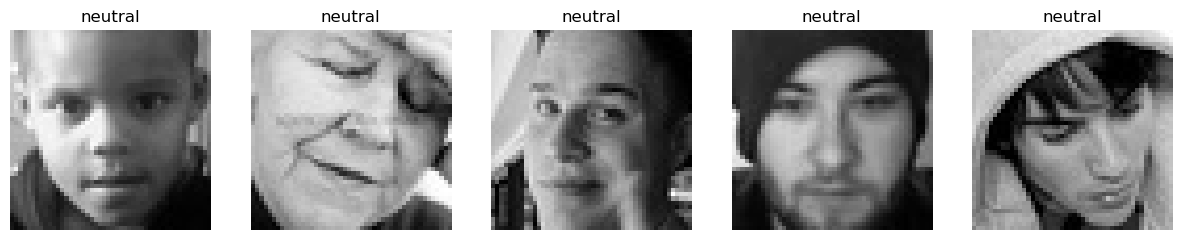

Label: fear


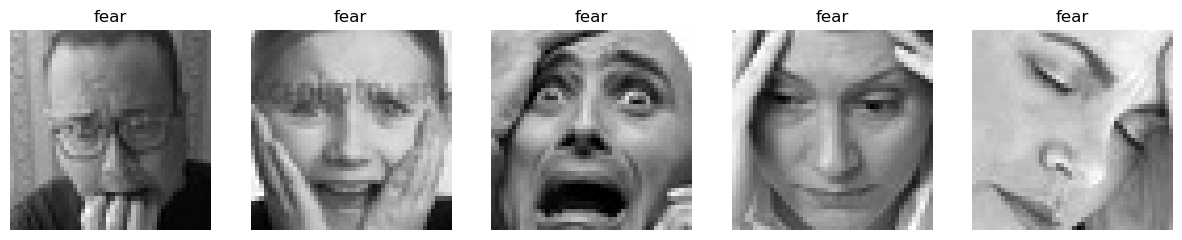

Label: angry


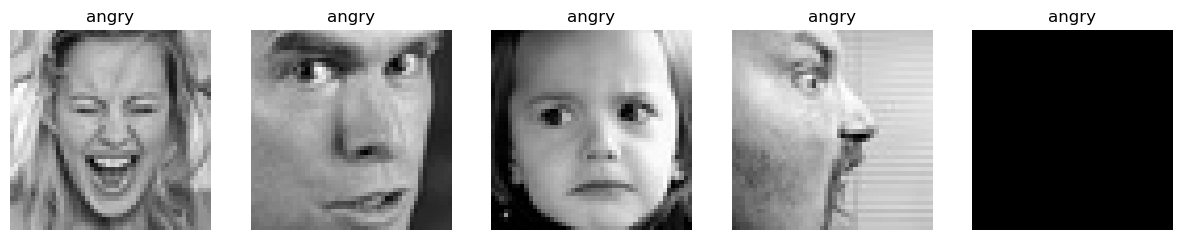

Label: surprise


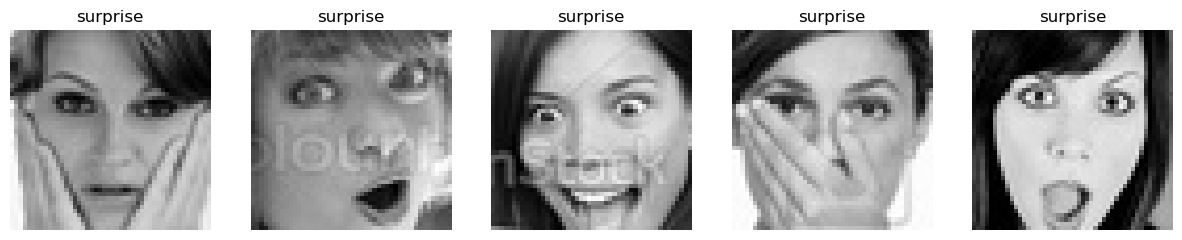

Label: disgust


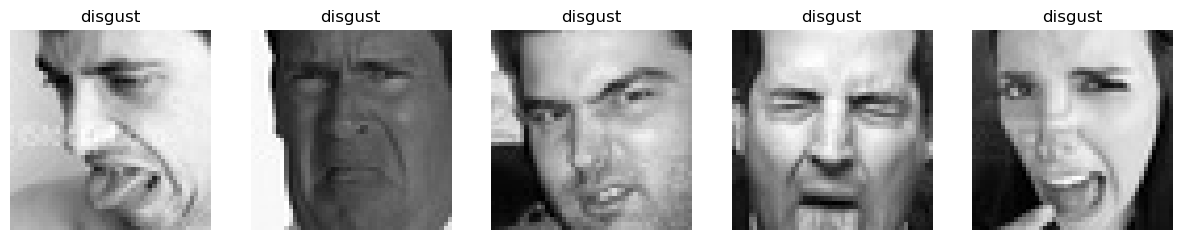

Label: happy


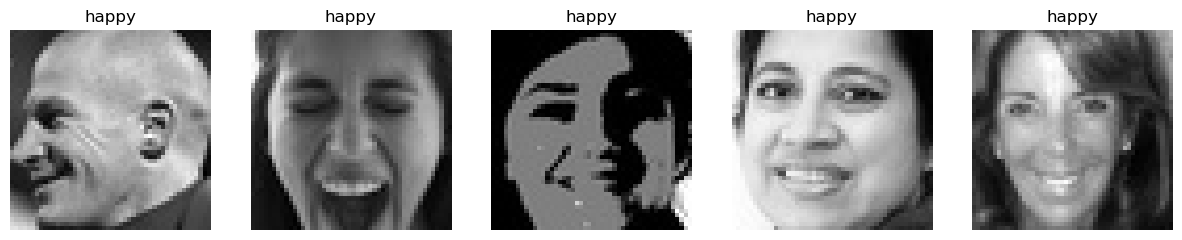

Label: sad


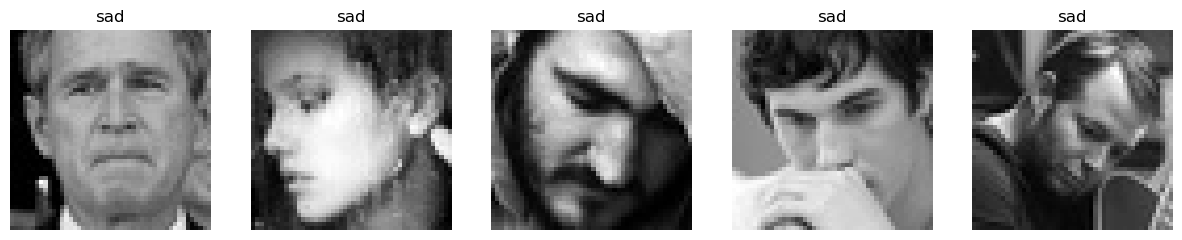

Label: neutral


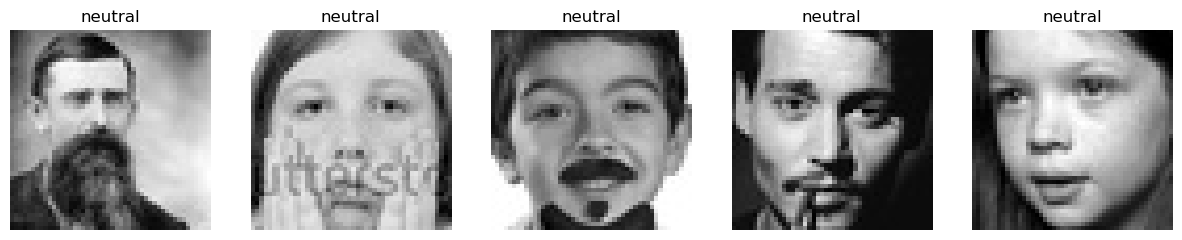

Label: fear


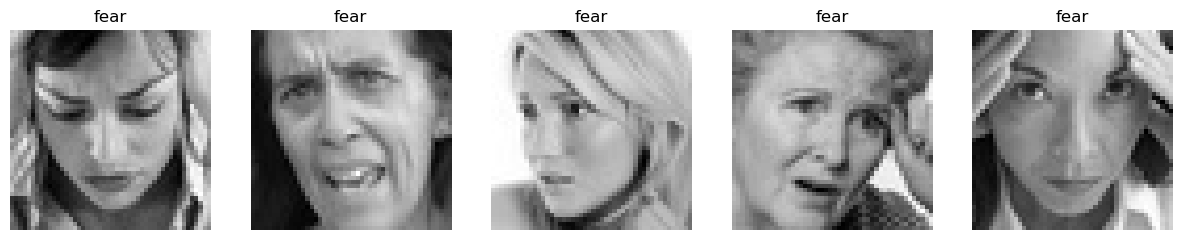

Label: angry


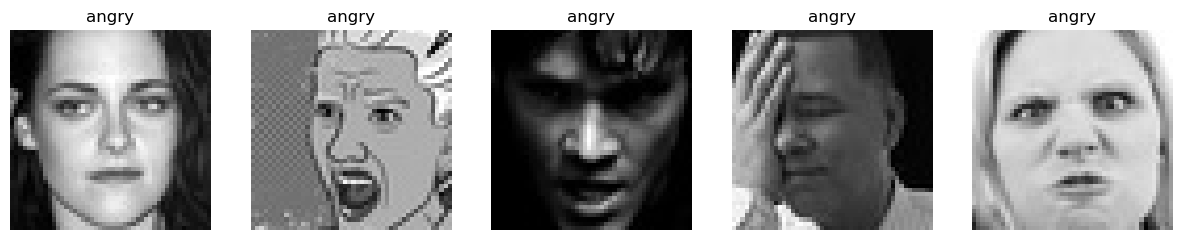

Label: surprise


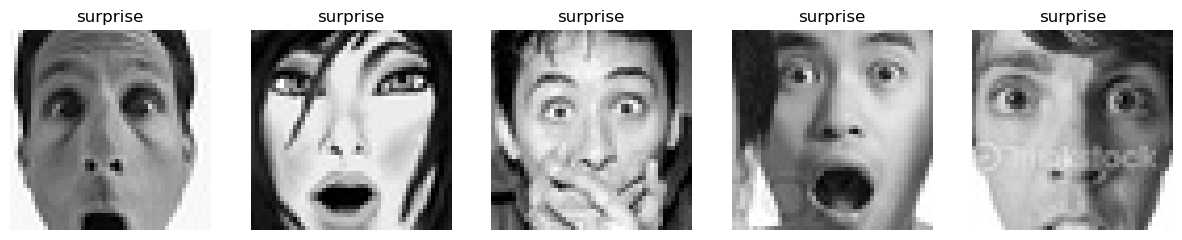

In [6]:
# Define a function to visualize random samples from each category
def visualize_samples(images, labels, num_samples=5, dataset_label="Dataset"):
    unique_labels = set(labels)
    
    for label in unique_labels:
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        
        print(f"Label: {label}")
        sample_images = random.sample(label_images, min(num_samples, len(label_images)))
        
        plt.figure(figsize=(15, 3))
        for i, image in enumerate(sample_images):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(image, cmap='gray')
            plt.title(label)
            plt.axis('off')
        
        plt.show()

# Visualize samples from training and testing
visualize_samples(train_images, train_labels, num_samples=5, dataset_label="Training")
visualize_samples(test_images, test_labels, num_samples=5, dataset_label="Testing")

Data Cleaning

In [7]:
# Define a function to check if images are loaded correctly and correct size
def check_images(images, labels, dataset_label="Dataset"):
    invalid_images = []
    for i, image in enumerate(images):
        if image is None or image.shape != (48, 48):
            print(f"Invalid image detected in {dataset_label} set: Label - {labels[i]}, Index - {i}")
            invalid_images.append((labels[i], i))  # Store label and index of invalid images
    print(f"Total invalid images in {dataset_label} set: {len(invalid_images)}")

# Check the training and testing sets in memory
check_images(train_images, train_labels, dataset_label="Training")
check_images(test_images, test_labels, dataset_label="Testing")

Total invalid images in Training set: 0
Total invalid images in Testing set: 0


Addressing Data Imbalance: Step 1 Downsample 'happy' to 5000 Images

In [9]:
# Directory to save the downsampled 'happy' images
balanced_happy_dir = os.path.expanduser('~/Downloads/fer2013/train_balanced/happy')
os.makedirs(balanced_happy_dir, exist_ok=True)

# Number of images to keep after downsampling
num_images_to_keep = 5000

# Get 'happy' images
happy_images = [img for img, label in zip(train_images, train_labels) if label == 'happy']

# Downsample 'happy'
if len(happy_images) >= num_images_to_keep:
    # Randomly select a subset of images
    selected_happy_images = random.sample(happy_images, num_images_to_keep)
    
    # Save the downsampled images to the new directory
    for i, image in enumerate(selected_happy_images):
        dest_path = os.path.join(balanced_happy_dir, f"happy_{i}.png")
        cv2.imwrite(dest_path, image)
    
    print(f"Downsampled 'happy' category to {num_images_to_keep} images in 'fer2013/train_balanced'.")
else:
    print(f"Not enough images to downsample to {num_images_to_keep}. Available images: {len(happy_images)}")

Downsampled 'happy' category to 5000 images in 'fer2013/train_balanced'.


Addressing Data Imbalance: Step 2 Augmentation

In [10]:
# Augment 'disgust' significantly, 'surprise' moderately, 'fear' and 'angry' lightly, keep 'sad' and 'neutral' as it is

# Directory for balanced data
train_balanced_dir = os.path.expanduser('~/Downloads/fer2013/train_balanced')
os.makedirs(train_balanced_dir, exist_ok=True)

# Augmentation pipeline
base_augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
    transforms.RandomRotation(10),  # Rotate +/- 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Translation and scaling
    transforms.ColorJitter(brightness=0.2, contrast=0.2)  # Adjust brightnedd and contrast
])

# Define a function to augment images and save to a new directory
def augment_images(images, label, target_directory, target_count):
    # Save original images
    for i, image in enumerate(images):
        dest_path = os.path.join(target_directory, f"{label}_{i}.png")
        cv2.imwrite(dest_path, image)

    # Calculate the number of augmentations needed
    num_augmentations = target_count - len(images)
    
    # Perform augmentations if needed
    if num_augmentations > 0:
        augmentation_count = 0
        while augmentation_count < num_augmentations:
            image = random.choice(images)
            pil_image = Image.fromarray(image)  # Convert to PIL for augmentation
            augmented_image = base_augmentation_transform(pil_image)
            augmented_image.save(os.path.join(target_directory, f"aug_{augmentation_count}_{label}.png"))
            augmentation_count += 1

# Categories to augment and their target counts
categories_to_augment = {
    'disgust': 5000,
    'surprise': 5000,
    'fear': 5000,
    'angry': 5000
}

# Apply augmentation to specified categories and save to train_balanced
for category, target_count in categories_to_augment.items():
    # Filter images and labels for the current category
    category_images = [img for img, lbl in zip(train_images, train_labels) if lbl == category]
    target_category_path = os.path.join(train_balanced_dir, category)
    os.makedirs(target_category_path, exist_ok=True)
    augment_images(category_images, category, target_category_path, target_count)

# Copy sad and neutral directly to train_balanced
unaltered_categories = ['sad', 'neutral']
for category in unaltered_categories:
    category_images = [img for img, lbl in zip(train_images, train_labels) if lbl == category]
    target_category_path = os.path.join(train_balanced_dir, category)
    os.makedirs(target_category_path, exist_ok=True)
    
    # Save images without augmentation
    for i, image in enumerate(category_images):
        dest_path = os.path.join(target_category_path, f"{category}_{i}.png")
        cv2.imwrite(dest_path, image)

print("Augmentation and copying completed for specified categories.")

Augmentation and copying completed for specified categories.


Count the Number of Images in Each Category

In [11]:
# Load training balanced dataset
train_images_balanced, train_labels_balanced = load_images_from_directory(train_balanced_dir)

# Count images in training balanced dataset
train_balanced_counts, num_train_images_balanced = count_images_per_category(train_labels_balanced, "Training")


Training set:
Category 'happy': 5000 images
Category 'sad': 4830 images
Category 'fear': 5000 images
Category 'surprise': 5000 images
Category 'neutral': 4965 images
Category 'angry': 5000 images
Category 'disgust': 5000 images
Total number of images in Training set: 34795


Feature Extraction for Training Balanced Dataset

In [12]:
# Define a function to extract HOG features
def extract_hog_features(images):
    features = []
    for image in images:
        hog_features = hog(
            image,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )
        features.append(hog_features)
    return np.array(features)

# Extract HOG features for training balanced dataset
train_features = extract_hog_features(train_images_balanced)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_balanced)

# Specify the directory to save extracted features and encoded labels
save_directory_features = os.path.expanduser('~/Downloads/fer2013/ExtractedFeatures')
os.makedirs(save_directory_features, exist_ok=True)

# Save HOG features and encoded labels
np.save(f'{save_directory_features}/train_HOG.npy', train_features)
np.save(f'{save_directory_features}/train_labels_encoded.npy', train_labels_encoded)
print("Features and labels saved successfully.")

Features and labels saved successfully.


In [13]:
# Load HOG features and encoded labels
train_features = np.load(f'{save_directory_features}/train_HOG.npy')
train_labels_encoded = np.load(f'{save_directory_features}/train_labels_encoded.npy')
print("Features and labels loaded successfully.")

# Print the shape of train_features
print("Shape of train HOG features:", train_features.shape)

Features and labels loaded successfully.
Shape of train HOG features: (34795, 900)


Visualizing HOG Features for Sample Images

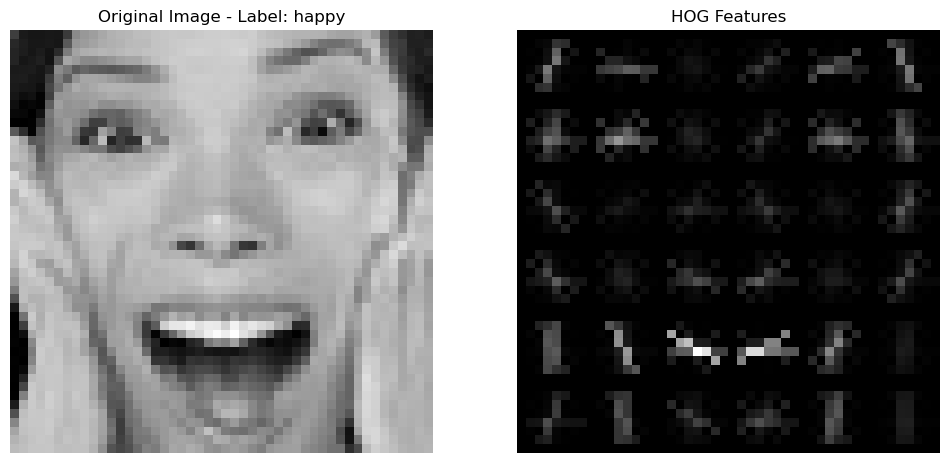

In [19]:
# Define a function to visualize HOG features for an image
def visualize_hog(image, label):
    # Recompute HOG features
    _, hog_image = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )
    
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original Image - Label: {label}')
    plt.axis('off')

    # HOG visualization
    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Features')
    plt.axis('off')

    plt.show()

# Visualize the HOG of a sample image from the training set
sample_index = 100
sample_image = train_images_balanced[sample_index]
sample_hog_feature = train_features[sample_index]
sample_label_encoded = train_labels_encoded[sample_index]

sample_label = label_encoder.inverse_transform([sample_label_encoded])[0]
visualize_hog(sample_image, sample_label)

